# Data ingestion & ETL.


In [12]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul 16 09:21:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# import cudf
# import cuml
import os
import numpy as np
import pandas as pd

In [14]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
%matplotlib inline

import warnings
from scipy import stats
warnings.filterwarnings('ignore')


In [15]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Conv1D, MaxPooling1D
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [16]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Amazon_10k_preprocessed_230701_v1.csv')
# df = df[['review','label', 'labels']]
df.head()

,review,label,labels
0,friend loved pair tenqa headphone bought pair ...,design_problem,1
1,read review made connect device computer monit...,design_problem,1
2,battery mah straightup falsehood got battery i...,customer_service_issues,3
3,purchased item compact solution low battery li...,customer_service_issues,3
4,got replace old sony disc player five year sta...,design_problem,1


In [17]:
# import pandas as pd

# df = pd.read_csv('/content/drive/MyDrive/aws_8k_equal_data.csv')
# df = df.sample(frac = 1)
# df.head()

In [18]:
df.isnull().sum()

review    0
label     0
labels    0
dtype: int64

In [19]:
# Map cluster labels to new labels
cluster_mapping = {
    'Manufacturing_defect': 0,
    'design_problem': 1,
    'no_defect_info': 2,
    'customer_service_issues': 2
}

# Assign labels to unlabeled reviews
df['labels'] = df['label'].map(cluster_mapping)

df.head()

,review,label,labels
0,friend loved pair tenqa headphone bought pair ...,design_problem,1
1,read review made connect device computer monit...,design_problem,1
2,battery mah straightup falsehood got battery i...,customer_service_issues,2
3,purchased item compact solution low battery li...,customer_service_issues,2
4,got replace old sony disc player five year sta...,design_problem,1


### GLoVe Embedding

In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-07-16 09:21:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-07-16 09:21:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-07-16 09:21:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [21]:
import os

In [22]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [23]:
# Create the training and testing datasets
# train_size = int(len(df) * 0.8) # Use 80% of the data for training
# train_data = df['review_body'][:train_size]
# test_data = df['review_body'][train_size:]
# train_labels = np.array(df['star_rating'][:train_size] <= 2) # Negative reviews are labeled as True
# test_labels = np.array(df['star_rating'][train_size:] <= 2)

#Preprocess the data
reviews = df['review'].values
labels = df['labels'].values




# Tokenize the text data
tokenizer = Tokenizer(num_words=10000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True, split=' ', char_level=False
                      )
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Create word embedding matrix
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

embedding_dim = 100  # Adjust the embedding dimension as needed
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Load pre-trained word embeddings (e.g., GloVe embeddings)
# Replace 'glove.6B.100d.txt' with the path to your pre-trained word embeddings file
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Split the data into training and testing sets
train_size = int(0.8 * len(sequences))

X_train = sequences[:train_size]
y_train = labels[:train_size]
X_test = sequences[train_size:]
y_test = labels[train_size:]






In [24]:
from sklearn.preprocessing import OrdinalEncoder

# Reshape the input array
y_train_reshaped = y_train.reshape(-1, 1)

# Create an instance of the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit the encoder on the target labels
ordinal_encoder.fit(y_train_reshaped)

# Transform the target labels using ordinal encoding
y_train_encoded = ordinal_encoder.transform(y_train_reshaped)
y_test_encoded = ordinal_encoder.transform(y_test.reshape(-1, 1))


In [25]:
# Step 4: Handle Class Imbalance with SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
# X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)


### Word2Vec Embedding

In [ ]:
from gensim.models import Word2Vec



In [ ]:
sentences = df.review.values
label = df.labels.values

In [ ]:
# Set the parameters for the Word2Vec model
embedding_dim = 300  # Set the desired dimensionality of the word embeddings
min_word_count = 5  # Ignore words with a frequency lower than this value
context_window = 5  # Set the size of the context window
sg = 1  # Use Skip-Gram model (sg=1), or CBOW (sg=0)

# Train the Word2Vec model
model = Word2Vec(sentences, vector_size=embedding_dim, window=context_window, min_count=min_word_count, sg=sg)


In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

sequences = tokenizer.texts_to_sequences(sentences)

max_length = max(len(seq) for seq in X_train_sequences)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

# Create word embedding matrix
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

embedding_dim = 300  # Adjust the embedding dimension as needed

embeddings_index = {}
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]




In [ ]:
train_size = int(0.8 * len(sequences))

X_train = sequences[:train_size]
y_train = label[:train_size]
X_test = sequences[train_size:]
y_test = label[train_size:]



In [ ]:
import numpy as np

# Compute class weights
class_labels = np.unique(y_train)
class_counts = np.bincount(y_train)
total_samples = np.sum(class_counts)
class_weights = total_samples / (len(class_labels) * class_counts)
class_weights_dict = dict(zip(class_labels, class_weights))




In [ ]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
# class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
class_weights

array([0.92165899, 0.54794521, 4.62962963, 1.14416476])

### Bert Tokenizer

In [ ]:
# !pip install transformers


In [ ]:
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

In [ ]:
X = df.review
y = df.labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Set the parameters for the Word2Vec model
embedding_dim = 300  # Set the desired dimensionality of the word embeddings
min_word_count = 5  # Ignore words with a frequency lower than this value
context_window = 5  # Set the size of the context window
sg = 1  # Use Skip-Gram model (sg=1), or CBOW (sg=0)

# Train the Word2Vec model
model = Word2Vec(X, vector_size=embedding_dim, window=context_window, min_count=min_word_count, sg=sg)

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

sequences = tokenizer.texts_to_sequences(sentences)

max_length = max(len(seq) for seq in X_train_sequences)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

# Create word embedding matrix
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

embedding_dim = 300  # Adjust the embedding dimension as needed

embeddings_index = {}
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]



In [ ]:
# Step 4: Handle Class Imbalance with SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_padded, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test_padded, y_test)


# CNN Classifier

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM


with tf.device("/device:GPU:0"):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Flatten, Dense

    # model = Sequential()

    # model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
    # model.add(Conv1D(filters= 64, kernel_size=3, padding='same', activation='relu'))
    # model.add(GlobalMaxPooling1D())
    # model.add(Dense(256, activation='relu'))
    # model.add(Dense(3, activation='softmax'))


    # model.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])


    # model.summary()
    # cnn_mdl = model.fit(X_train_resampled, y_train_resampled,
    #                     validation_data=(X_test, y_test),
    #                     epochs=50,
    #                     batch_size=64)
    #                     # ,class_weight=class_weight)

    model = Sequential()

    model.add(Embedding(vocab_size, 300, input_length= max_sequence_length))


    model.add(Conv1D(64, 2, padding='same', activation='relu'))
    model.add(MaxPooling1D(2))

    model.add(Flatten())
    model.add(Dense(units=1024,activation="relu"))
    model.add(Dense(units=512,activation="relu"))
    model.add(Dense(units=3,activation="softmax"))

    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.9,beta_2=0.999)
    model.compile(optimizer=optimizer,metrics=["accuracy"],loss='sparse_categorical_crossentropy')

    model.summary()
    cnn_mdl = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=10,
                        batch_size=64)
                        # ,class_weight=class_weight)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1032, 300)         4376400   
                                                                 
 conv1d_13 (Conv1D)          (None, 1032, 64)          38464     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 516, 64)          0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 33024)             0         
                                                                 
 dense_23 (Dense)            (None, 1024)              33817600  
                                                                 
 dense_24 (Dense)            (None, 512)               524800    
                                                     

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


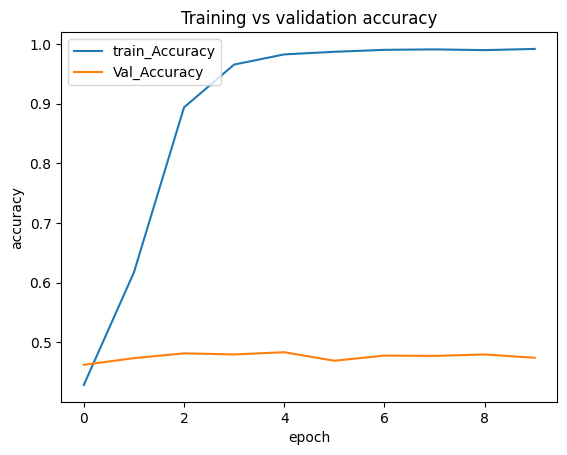

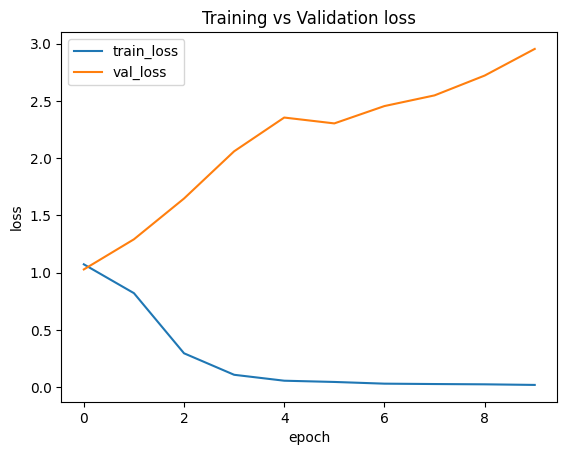

In [ ]:
# Visualize training history
import matplotlib.pyplot as plt

print(cnn_mdl.history.keys())
# summarize history for accuracy
plt.plot(cnn_mdl.history['accuracy'])
plt.plot(cnn_mdl.history['val_accuracy'])
plt.title('Training vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_Accuracy', 'Val_Accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn_mdl.history['loss'])
plt.plot(cnn_mdl.history['val_loss'])
plt.title('Training vs Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [ ]:
from keras import backend as K

def recall_m(y_true,y_pred):
  true_pos = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_pos / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_pos / (predicted_positives + K.epsilon())
  return precision


def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras import backend as K
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def recall_m(y_true, y_pred):
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_pos / (possible_positives + K.epsilon())
    return K.mean(recall)

def precision_m(y_true, y_pred):
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    precision = true_pos / (predicted_positives + K.epsilon())
    return K.mean(precision)

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return K.mean(f1)

def weighted_recall(y_true, y_pred):
    y_true_labels = np.argmax(K.eval(y_true), axis=1)
    y_pred_labels = np.argmax(K.eval(y_pred), axis=1)
    return recall_score(y_true_labels, y_pred_labels, average='weighted')

def weighted_precision(y_true, y_pred):
    y_true_labels = np.argmax(K.eval(y_true), axis=1)
    y_pred_labels = np.argmax(K.eval(y_pred), axis=1)
    return precision_score(y_true_labels, y_pred_labels, average='weighted')

def weighted_f1(y_true, y_pred):
    y_true_labels = np.argmax(K.eval(y_true), axis=1)
    y_pred_labels = np.argmax(K.eval(y_pred), axis=1)
    return f1_score(y_true_labels, y_pred_labels, average='weighted')


In [ ]:
# Build the RNN model
%%time
with tf.device("/device:GPU:0"):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],trainable = False))

    model.add(Dropout(0.35))
    model.add(Conv1D(filters =64 ,kernel_size = 5,padding='valid',activation='relu',strides=1))
    model.add(MaxPooling1D(pool_size= 4))

    model.add(CuDNNLSTM(64))
    model.add(Dense(3, activation='softmax'))

    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.9,beta_2=0.999)
    model.compile(optimizer=optimizer,
                  metrics= ['accuracy',f1_m,precision_m, recall_m],
                  loss='sparse_categorical_crossentropy')

    model.summary()
    # Train the model
    # rnn_mdl = model.fit(train_seq, train_labels,
    #           validation_data=(test_seq, test_labels),
    #           epochs=50,
    #           batch_size=64)

    rnn_mdl = model.fit(X_train_resampled, y_train_resampled,
                        batch_size=64,
                        epochs=50,
                        validation_data=(X_test, y_test_encoded))


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 100)         1458800   
                                                                 
 dropout_11 (Dropout)        (None, None, 100)         0         
                                                                 
 conv1d_11 (Conv1D)          (None, None, 64)          32064     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 module_wrapper_11 (ModuleWr  (None, 64)               33280     
 apper)                                                          
                                                                 
 dense_11 (Dense)            (None, 3)               

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

cnn_mdl = rnn_mdl.model

# Obtain predictions from the model
y_pred = cnn_mdl.predict(X_test)

# Assuming you have the true labels already encoded as y_test_encoded

y_pred = np.argmax(y_pred, axis=1)
y_true = y_test_encoded

# Calculate precision, recall, and F1 score per class
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_score_per_class = f1_score(y_true, y_pred, average=None)

# Calculate weighted precision, recall, and F1 score
weighted_precision = precision_score(y_true, y_pred, average='weighted')
weighted_recall = recall_score(y_true, y_pred, average='weighted')
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')


51/51 [==============================] - 1s 7ms/step


In [ ]:
print('Weighted Precision Score: ',weighted_precision)
print('Weighted Recall Score: ',weighted_recall)
print('Weighted f1-Score Score: ',weighted_f1_score)

Weighted Precision Score:  0.4580135582251519
Weighted Recall Score:  0.4581005586592179
Weighted f1-Score Score:  0.4579422053281638


In [ ]:
# Assuming you have trained a model and obtained the predictions on the test dataset
y_pred = model.predict(X_test)  # X_test represents your test dataset

# Convert the predicted probabilities to predicted class labels
predicted_labels = np.argmax(y_pred, axis=1)

# Convert the true labels to the appropriate format if necessary
true_labels = y_test  # Assuming y_test represents the true labels of your test dataset


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import plotly.graph_objects as go

# Obtain the predicted class labels and true class labels
predicted_labels = y_pred # Numpy array or Pandas Series of predicted labels
true_labels = y_true[:, 0]  # Numpy array or Pandas Series of true labels

# Create a contingency table
contingency_table = pd.crosstab(predicted_labels, true_labels)

# Perform the chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Print the contingency table
print("Contingency Table:")
print(contingency_table)

# Print the chi-square statistic and p-value
print("Chi-square statistic:", chi2)
print("p-value:", p_value)


# Convert p-value to 4 decimal places
p_value = '{:.8f}'.format(p_value)


fig = go.Figure(data=[go.Table(header=dict(values=contingency_table.columns),
                               cells=dict(values=[contingency_table[col] for col in contingency_table.columns]))
                     ])

fig.update_layout(title="Contingency Table")
fig.show()

# Print the chi-square statistic and rounded p-value
print("Chi-square statistic:", chi2)
print("p-value:", p_value)

Contingency Table:
col_0  0.0  1.0  2.0
row_0               
0      283  154  150
1      148  220  147
2      139  135  235
Chi-square statistic: 112.44241613823476
p-value: 2.1927877287872368e-23


Chi-square statistic: 112.44241613823476
p-value: 0.00000000


In [ ]:
predicted_labels

array([0, 0, 1, ..., 2, 0, 2])

In [ ]:
true_labels

array([[2.],
       [2.],
       [0.],
       ...,
       [2.],
       [0.],
       [2.]])

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


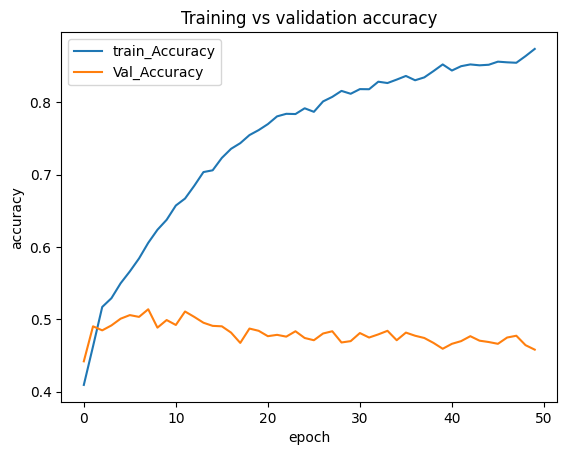

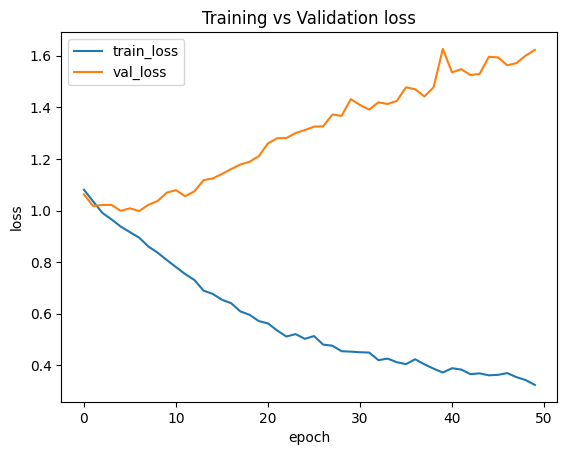

In [ ]:
# Visualize training history
import matplotlib.pyplot as plt

print(rnn_mdl.history.keys())
# summarize history for accuracy
plt.plot(rnn_mdl.history['accuracy'])
plt.plot(rnn_mdl.history['val_accuracy'])
plt.title('Training vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_Accuracy', 'Val_Accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(rnn_mdl.history['loss'])
plt.plot(rnn_mdl.history['val_loss'])
plt.title('Training vs Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [ ]:
with tf.device("/device:GPU:0"):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Flatten, Dense,GRU

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

    model.summary()



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1109, 300)         4205100   
                                                                 
 conv1d_4 (Conv1D)           (None, 1109, 128)         153728    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,358,957
Trainable params: 153,857
Non-trainable params: 4,205,100
_________________________________________________________________


In [ ]:
# num_epochs =10
# batch_size = 128
# history = model.fit(X_sm, y_sm,
#                     batch_size=batch_size,
#                     epochs=num_epochs,
#                     verbose=2,
#                     class_weight=class_weight,
#                     validation_split=0.2)
cnn_mdl = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_test_resampled, y_test_resampled),
                    epochs=50,
                    batch_size=64,
                    class_weight =  class_weights_dict)



Epoch 1/50
182/182 [==============================] - 6s 30ms/step - loss: 0.4866 - accuracy: 0.5002 - val_loss: 0.7286 - val_accuracy: 0.5000
Epoch 2/50
182/182 [==============================] - 6s 31ms/step - loss: 0.4862 - accuracy: 0.5009 - val_loss: 0.7313 - val_accuracy: 0.5000
Epoch 3/50
182/182 [==============================] - 6s 36ms/step - loss: 0.4856 - accuracy: 0.5023 - val_loss: 0.7136 - val_accuracy: 0.5000
Epoch 4/50
 78/182 [===========>..................] - ETA: 3s - loss: 0.4845 - accuracy: 0.5008

KeyboardInterrupt: ignored

In [ ]:
# from keras.models import Sequential
# from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# model = Sequential()
# # model.add(Dropout(0.35))
# model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# model.summary()
# cnn_mdl = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)



In [ ]:
from keras import backend as K

def recall_m(y_true,y_pred):
  true_pos = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_pos / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_pos / (predicted_positives + K.epsilon())
  return precision


def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

(0.9678, 0.9395, 9082, 0.9101)

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

def plot_mdl(cnn_mdl):
  accuracy = cnn_mdl.history['accuracy']
  val_accuracy = cnn_mdl.history['val_accuracy']
  loss = cnn_mdl.history['loss']
  val_loss = cnn_mdl.history['val_loss']
  x = range(1,len(accuracy)+1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, accuracy, 'b', label='Train_accuracy')
  plt.plot(x, val_accuracy, 'ro', label='Val_accuracy')
  plt.title('Training vs validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Train_loss')
  plt.plot(x, val_loss, 'ro', label='Val_loss')
  plt.title('Training vs validation loss')
  plt.legend()



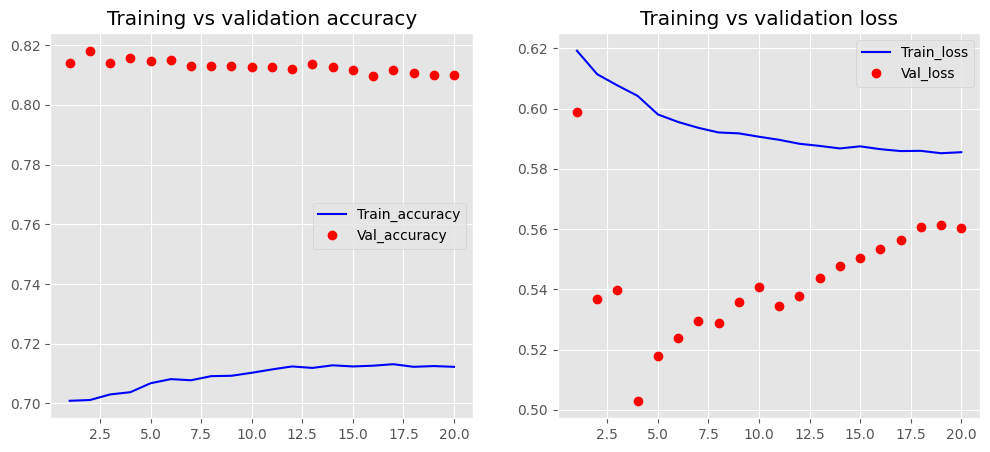

In [ ]:
# loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, y_train,verbose=False)

# print("--Classify negative and non-negative customer reviews, Model 1--")
# print("Training Accuracy: {:.4f} Training F1 Score: {:.4f}".format(accuracy,f1_score))
# print("Training Precision: {:.4f} Training Recall: {:.4f}".format(precision, recall))

# Evaluate the model
# loss, accuracy,f1_score, precision, recall = model.evaluate(X_test, y_test)
# print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
# print("Test Precision: {:.4f} Test Recall: {:.4f}".format(precision, recall))

plot_mdl(cnn_mdl)



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score,auc ,roc_curve,precision_score, recall_score,confusion_matrix


In [ ]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

63/63 [==============================] - 1s 6ms/step


ValueError: ignored

In [ ]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

In [ ]:
# Accuracy data for Group 1
group1_accuracy = [0.9079, 0.9678, 0.9395,9082,0.9101]

# Accuracy data for Group 2
group2_accuracy = [0.8795,0.8800,0.8810,0.8730,0.8795]

# Perform t-test
t_statistic, p_value_t = ttest_ind(group1_accuracy, group2_accuracy)

# Perform Mann-Whitney U test
u_statistic, p_value_u = mannwhitneyu(group1_accuracy, group2_accuracy)

# Print the results
print("T-Test:")
print("T-Statistic:", t_statistic)
print("P-Value:", p_value_t)

print("\nMann-Whitney U Test:")
print("U-Statistic:", u_statistic)
print("P-Value:", p_value_u)

T-Test:
T-Statistic: 1.000029030155116
P-Value: 0.34658029231243564

Mann-Whitney U Test:
U-Statistic: 25.0
P-Value: 0.0119252335930176


In [ ]:
from scipy import stats

# total number of test reviews
test_reviews = 2000
# Number of successes (accurately predicted reviews) = int(0.9079 * test_reviews)
accurate_predictions = 1815
# Null hypothesis (expected probability of success)
null_hypothesis = 0.5

# Perform binomial test
p_value = stats.binom_test(accurate_predictions, test_reviews, null_hypothesis)

# Calculate the expected number of successes under the null hypothesis
expected_successes = null_hypothesis * test_reviews

# Calculate the test statistic
test_statistic = (accurate_predictions - expected_successes) / (test_reviews * null_hypothesis * (1 - null_hypothesis))**0.5

print("Binomial Test:")
# Print the test statistic
print("Test statistic:", test_statistic)
# Print the p-value
print("P-value:", p_value)

Binomial Test:
Test statistic: 36.44790803324657
P-value: 0.0


<ipython-input-2-2f0c9a4c72ae>:11: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = stats.binom_test(accurate_predictions, test_reviews, null_hypothesis)


#CRAN - Attention layer

In [26]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Attention, concatenate

# Define input shape
input_shape = (100, 300)  # Length of input sequence and size of word embeddings

# Define CNN layer
num_filters = 128
filter_sizes = [3, 4, 5]
conv_layers = []
for filter_size in filter_sizes:
    conv_layer = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(input_layer)
    pool_layer = GlobalMaxPooling1D()(conv_layer)
    conv_layers.append(pool_layer)
cnn_output = concatenate(conv_layers)

# Define RNN layer
rnn_units = 64
rnn_layer = LSTM(units=rnn_units, return_sequences=True)(cnn_output)

# Define attention layer
attention = Attention()(rnn_layer)

# Define topic extraction layer
num_topics = 10
topic_output = Dense(units=num_topics, activation='softmax')(attention)

# Create the model
model = Model(inputs=input_layer, outputs=topic_output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))


NameError: ignored